In [1]:
from doodle.dosimetry.OrganSDosimetry import OrganSDosimetry
from doodle.ImagingTools.Tools import create_logitudinal_from_dicom, load_and_resample_RT
from doodle.ImagingDS.LongStudy import LongitudinalStudy
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
import pandas
import numpy as np
import math

# Autoreload magic
%load_ext autoreload
%autoreload 2

# PyTheranostic version
# commit 7d9d6fd5cc471b63aacf6f49818e8bd9dac4f924

In [2]:
# Prepare DataStructures for CT and NM Data
db_dir = Path("/mnt/y/Sara/HTK/Dosimetry/LUHTK03170-01/cycle01")

# Set Paths to each time point. 
time_points = [db_dir / "tp1", db_dir / "tp2", db_dir / "tp3", db_dir / "tp4"]

# Create Longitudinal Studies:
ct_paths = []
ctac_paths = []
spect_paths = []

for dir in time_points:
    ct_paths.append(str(dir / "CT"))
    ctac_paths.append(str(dir / "CTAC"))
    spect_paths.append(str(dir / "SPECT"))

longCT = create_logitudinal_from_dicom(dicom_dirs=ct_paths, modality="CT")
longCTAC = create_logitudinal_from_dicom(dicom_dirs=ctac_paths, modality="CT")
longSPECT = create_logitudinal_from_dicom(dicom_dirs=spect_paths, modality="Lu177_SPECT")

# Add Masks: Here we need to read RTStruct from CT, and re-sample to CTAC (== SPECT) frame.
ct_masks = {}
ctac_masks = {}

for time_id, dir in enumerate(time_points):
    print(f"Loading Time Point {time_id}, {dir}")
    ct_, ctac_ = load_and_resample_RT(ref_dicom_dir=str(dir / "CT"), rt_struct_dir = str(dir / "CT" / "RTstruct"),
                                      target_shape=longCTAC.images[time_id].GetSize())
    
    longCT.add_masks_to_time_point(time_id=time_id, masks=ct_, strict = False)
    longCTAC.add_masks_to_time_point(time_id=time_id, masks=ctac_, strict = False)
    longSPECT.add_masks_to_time_point(time_id=time_id, masks=ctac_, strict = False)


Loading Time Point 0, /mnt/y/Sara/HTK/Dosimetry/LUHTK03170-01/cycle01/tp1
Loading Time Point 1, /mnt/y/Sara/HTK/Dosimetry/LUHTK03170-01/cycle01/tp2
Loading Time Point 2, /mnt/y/Sara/HTK/Dosimetry/LUHTK03170-01/cycle01/tp3
Loading Time Point 3, /mnt/y/Sara/HTK/Dosimetry/LUHTK03170-01/cycle01/tp4


In [3]:
def prepare_lu177_blood_assay(path_to_xlsx: str, 
                              cal_factor: float, 
                              volume: float, 
                              inj_date: str,
                              haematocrit: float = 0.81) -> pandas.DataFrame:
    """Convert our blood assay data into format suitable for pyTheranostics Clinical Data
    Parameters:
        path_to_xslx: path to excel spreadsheet.
        cal_factor: convertion factor from cpm to Bq.
        volume: volume of blood in assay vial
        inj_date: injectiond ate, in YYYYMMDD HHMMSS format.
        haematocrit: value from patient. By default we use 0.81, which would result in a RMBLR of 1. (RMBLR = 0.19/(1-HCT))
        # TODO
    """
    blood = pandas.read_excel(path_to_xlsx)
    
    blood = blood.drop(labels=["Tags", "Lu-177 (Bq)"], axis=1)
    blood["Lu-177 (Bq)"] = blood["Lu-177 (CPM)"] * cal_factor
    blood["Volume_mL"] = volume

    blood["Injection date & time (yyyymmdd hhmmss)"] = datetime.strptime(inj_date, "%Y%m%d %H%M%S")

    # Calculate activity at collection time
    time_stamp_diff = (blood["Collection date & time (yyyy-mm-dd)"] - blood["Measurement date & time (yyyy-mm-dd)"]).tolist()
    
    blood["Delta Time Meas - Col (days)"] = [diff.total_seconds() / (3600 * 24) for diff in time_stamp_diff]
    blood["Activity_Bq"] = blood["Lu-177 (Bq)"] * np.exp(-math.log(2) / 6.647 * blood["Delta Time Meas - Col (days)"])

    # Collection time expressed with respect to injection
    time_stamp_diff = (blood["Collection date & time (yyyy-mm-dd)"] - blood["Injection date & time (yyyymmdd hhmmss)"]).tolist()
    blood["Time_hr"] = [diff.total_seconds() / 3600 for diff in time_stamp_diff]

    
    # Remove unused columns
    blood["PatientID"] = blood["patient_id"]
    remove = [col for col in blood.keys() if col not in ["PatientID", "Time_hr", "Activity_Bq", "Volume_mL"]]
    blood = blood.drop(labels=remove, axis=1)

    blood["Haematocrit"] = haematocrit

    return blood

In [5]:
# Configuration File

config_olinda = {
    "Operator": "SK",
    "PatientID": "LuHTK03170-01",
    "Cycle": 1,
    "DatabaseDir": "./TestDoseDB",
    "InjectionDate": "20240131",   
    "InjectionTime": "120000", 
    "InjectedActivity": "1120.71", 
    "Radionuclide": "Lu177",
    "Gender": "Male",
    "rois": {'Bladder_Experimental': {"fit_order": 1, 'param_init': (10, 0.01), 'through_origin': False}, # 1 for mono, 2 for bi, 3 for tri-exponential
            'Kidney_L_m': {"fit_order": -2, 'param_init': (10**2, 0.01, 0.1), 'through_origin': False},
            'Kidney_R_m': {"fit_order": -2, 'param_init': (10**2, 0.01, 0.1), 'through_origin': False},
            'Liver': {"fit_order": 1, 'param_init': (10, 0.01), 'through_origin': False},
            'ParotidglandL': {"fit_order": -2, 'param_init': (5, 0.01, 0.1), 'through_origin': False},
            'ParotidglandR': {"fit_order": 1, 'param_init': (10, 0.01), 'through_origin': False},
            'Skeleton': {"fit_order": 1, 'param_init': (10, 0.01), 'through_origin': False},
            'Spleen': {"fit_order": 1, 'param_init': (10, 0.01) ,'through_origin': False},
            'SubmandibularglandL': {"fit_order": 1, 'param_init': (10, 0.01), 'through_origin': False},
            'SubmandibularglandR': {"fit_order": 1, 'param_init': (10, 0.01), 'through_origin': False},
            'WBCT': {"fit_order": 1, 'param_init': (10, 0.01), 'through_origin': False}, 
            'BoneMarrow': {"fit_order": 3, 'param_init': (10, 0.1, 10, 0.1, 0.1), 'through_origin': True}
            },
    
    "Level": "Organ", 
    "Method": "S-Value", 
}

# Apply calibration factor to blood assay data.
path_xlsx = "/mnt/y/Sara/HTK/Dosimetry/LUHTK03170-01/cycle01/HTK_BloodCountData.xlsx"
cal_factor = 4.38e-4 * 1000 # Bq/cpm 
clinical_data = prepare_lu177_blood_assay(path_to_xlsx=path_xlsx,
                                          cal_factor=cal_factor,
                                          volume=1,
                                          inj_date=f"{config_olinda['InjectionDate']} {config_olinda['InjectionTime']}")


# PAth to Olinda results
olinda_results_path = '/home/skurkowska/HTK_dosimetry/HTK_Dosimetry/LUHTK03170-01.txt'


No Reference Time point was given. Assigning time ID = 0
Database search function not implemented. Dosimetry for this patient might already exists...
Although mask for Cavity_Oral_Experimental is present, we are ignoring it because this region was not included in the configuration input file.
Although mask for LN_Iliac_Experimental is present, we are ignoring it because this region was not included in the configuration input file.
Although mask for Liver_Reference is present, we are ignoring it because this region was not included in the configuration input file.
Although mask for Kidney_L_a is present, we are ignoring it because this region was not included in the configuration input file.
Although mask for Kidney_R_a is present, we are ignoring it because this region was not included in the configuration input file.
Although mask for Humerus_L is present, we are ignoring it because this region was not included in the configuration input file.
Although mask for Humerus_R is present, w

/home/skurkowska/doodle/doodle/fits/functions.py:18: RuntimeWarning: overflow encountered in exp
  return a * exp(-b * x) + c * exp(-d * x) - (a+c) * exp(-f * x)
/home/skurkowska/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


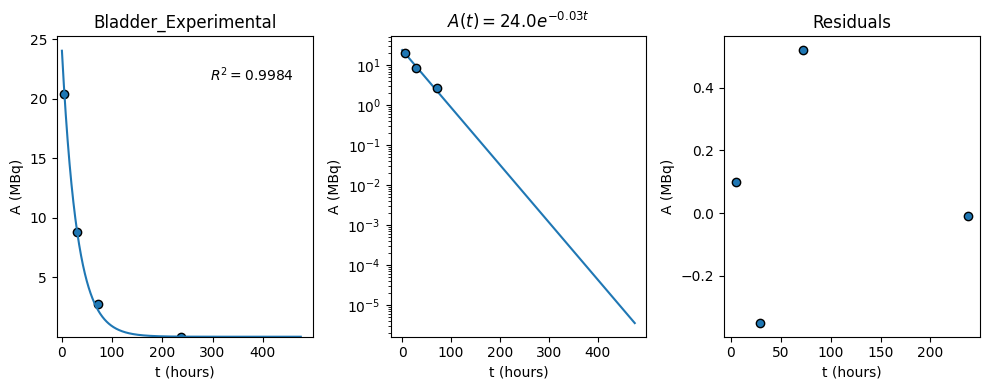

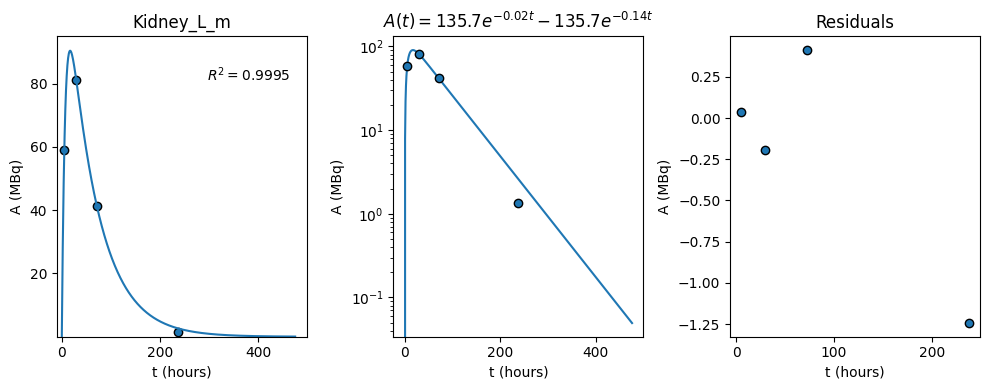

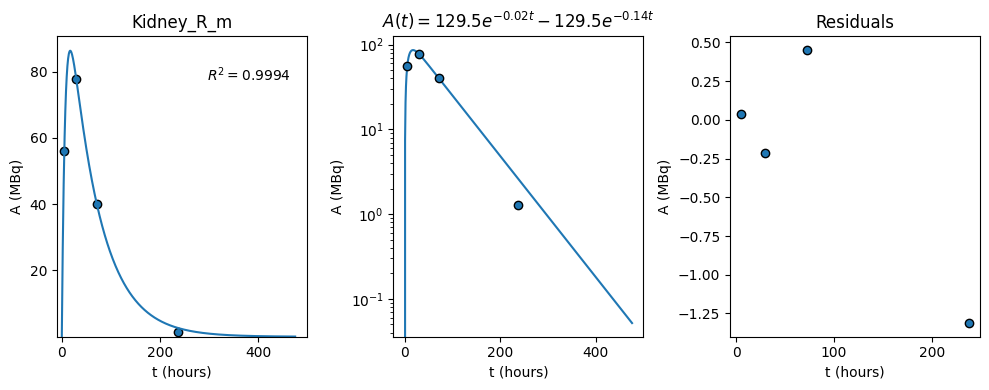

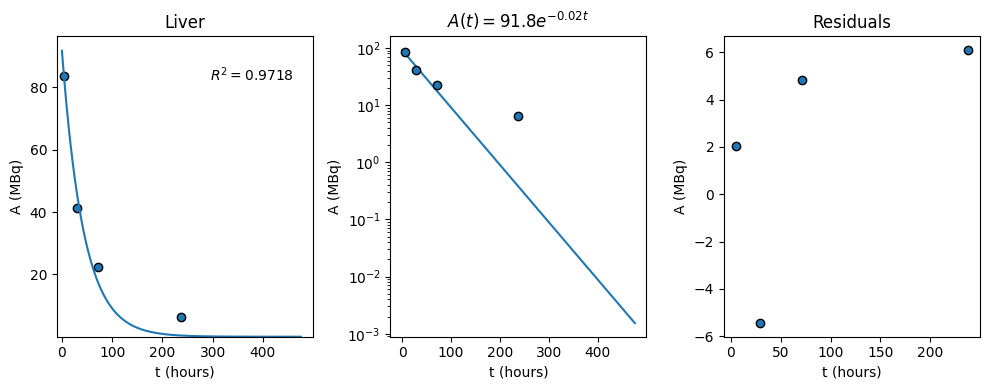

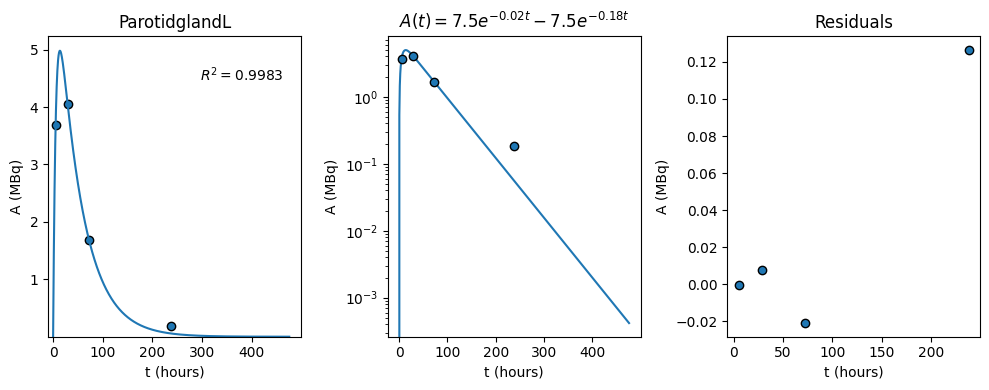

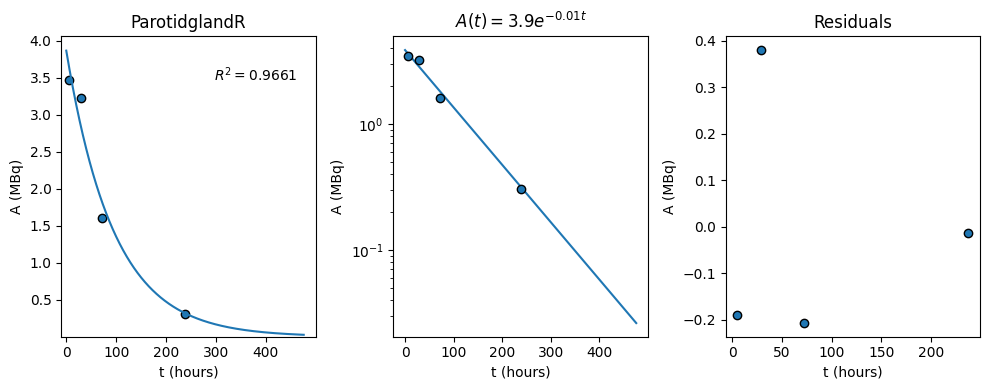

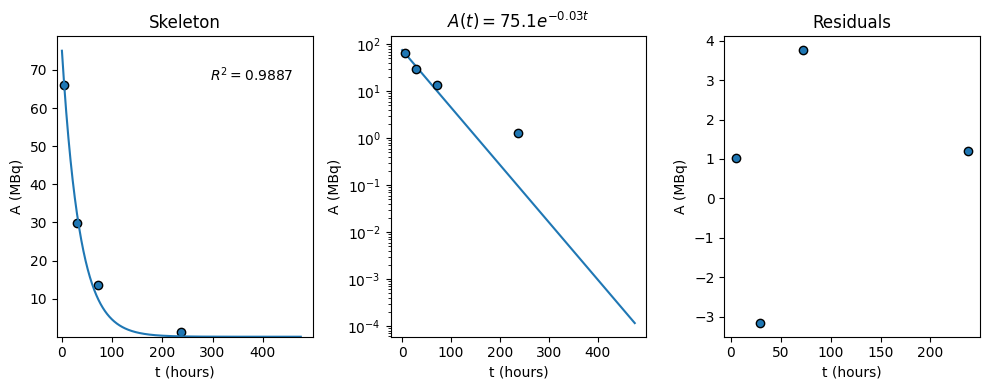

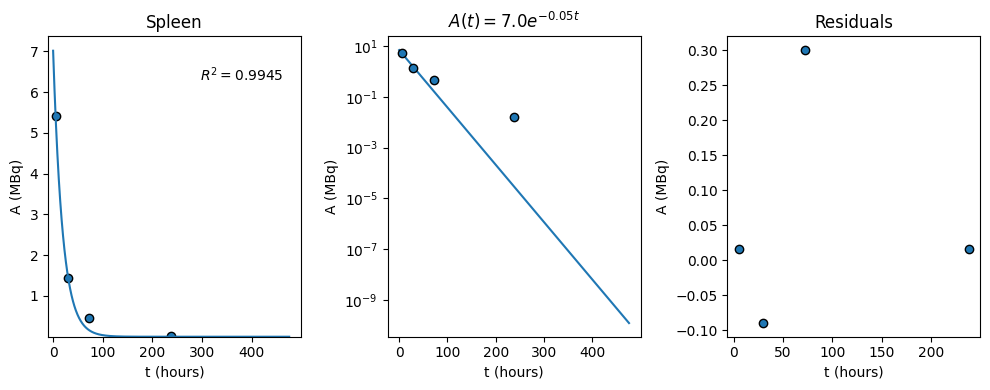

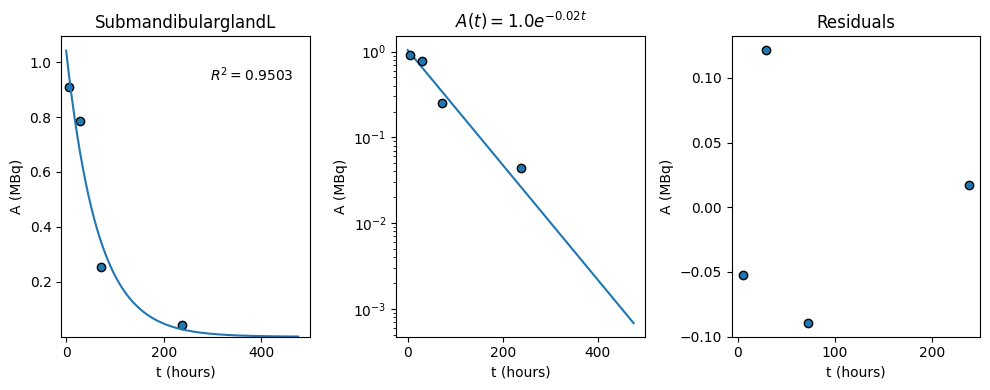

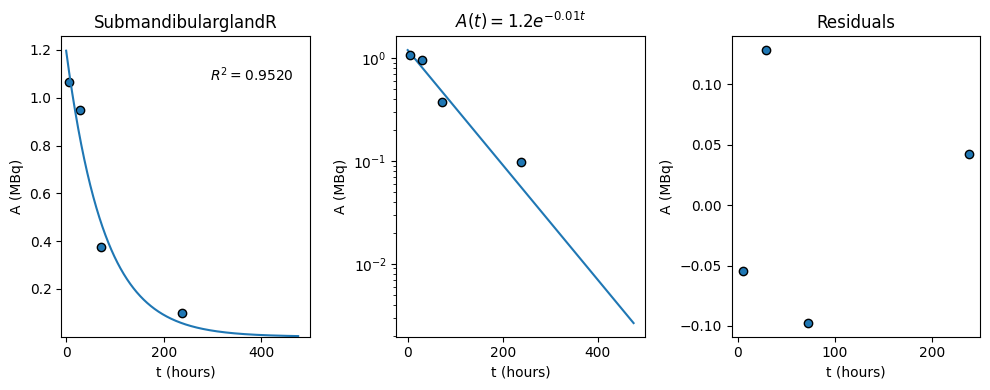

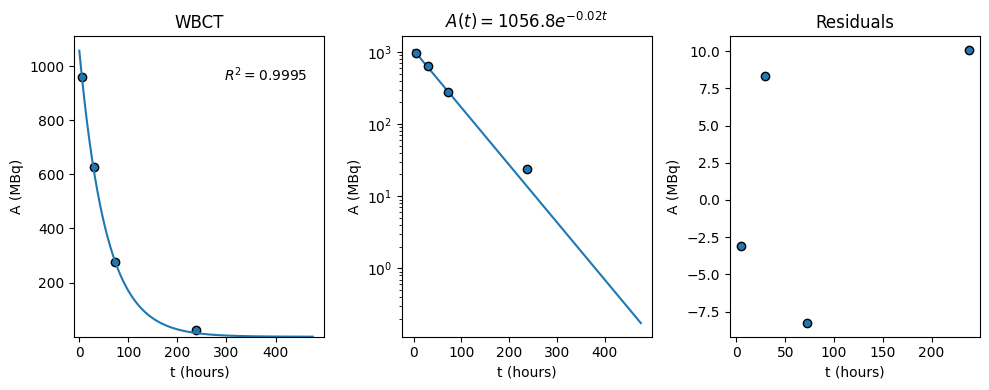

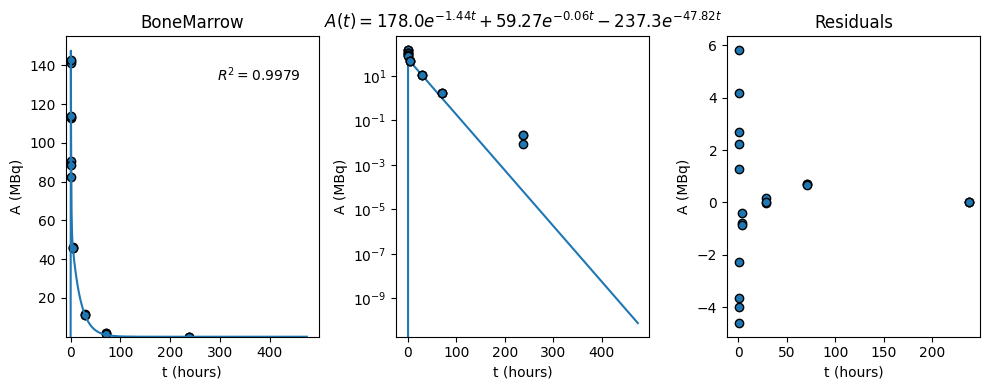

In [6]:
DoseCalculator = OrganSDosimetry(config=config_olinda, 
                               nm_data=longSPECT, 
                               ct_data=longCTAC,
                               clinical_data=clinical_data)
DoseCalculator.compute_dose()

In [7]:
DoseCalculator.results

,Time_hr,Volume_CT_mL,Activity_MBq,Fit_params,TIAC_MBq_h,TIAC_h,Lambda_eff
Bladder_Experimental,"[5.063888888888889, 29.25722222222222, 71.9244...","[415.0207412426371, 506.9779636221823, 208.833...","[20.441267999999997, 8.794364999999999, 2.7540...","[24.04490398875169, 0.03303968434731894, 0.998...","(727.7582841284209, 2.74816950567372e-06)",0.649370,24.044904
Kidney_L_m,"[5.063888888888889, 29.25722222222222, 71.9244...","[197.69718093731356, 214.78753221748826, 206.0...","[59.074163999999996, 81.144072, 41.409528, 1.3...","[135.67884229875204, 0.016638011922984846, 0.1...","(7207.80365089796, 8.350300328655025e-06)",6.431437,135.678842
Kidney_R_m,"[5.063888888888889, 29.25722222222222, 71.9244...","[181.37861831672103, 203.65121766206408, 195.8...","[56.033772, 77.767056, 40.121756, 1.27703875]","[129.45699784389004, 0.016442191217383415, 0.1...","(6960.819977238776, 4.8816001888968286e-05)",6.211056,129.456998
Liver,"[5.063888888888889, 29.25722222222222, 71.9244...","[1711.5746456720126, 1708.3768091261618, 1632....","[83.68512799999999, 41.227604, 22.227183999999...","[91.76643795199348, 0.023112226051791685, 0.97...","(3970.471634638564, 1.2306988161955162e-06)",3.542804,91.766438
ParotidglandL,"[5.063888888888889, 29.25722222222222, 71.9244...","[22.382893324191105, 20.949502629015797, 18.63...","[3.695401, 4.0568805, 1.67892825, 0.182252515625]","[7.467986598564759, 0.02057721121179923, 0.177...","(320.956303514842, 2.589597890642918e-06)",0.286385,7.467987
ParotidglandR,"[5.063888888888889, 29.25722222222222, 71.9244...","[25.800970629855758, 18.413510205503357, 18.96...","[3.4751784999999997, 3.2232445, 1.609777249999...","[3.8660674512953666, 0.01049879753299105, 0.96...","(368.23907110759774, 1.6294982491216019e-06)",0.328575,3.866067
Skeleton,"[5.063888888888889, 29.25722222222222, 71.9244...","[5694.406530679063, 5859.3553642554125, 5755.4...","[66.11657199999999, 29.793249999999997, 13.691...","[75.05215068759847, 0.02812612819664863, 0.988...","(2668.413873493662, 4.538673251073275e-07)",2.380994,75.052151
Spleen,"[5.063888888888889, 29.25722222222222, 71.9244...","[95.15486176737402, 87.87765050171363, 79.8286...","[5.403957, 1.438607875, 0.4656343125, 0.015498...","[7.013342134386529, 0.052074213531061384, 0.99...","(134.67975143212087, 9.904324805635437e-08)",0.120173,7.013342
SubmandibularglandL,"[5.063888888888889, 29.25722222222222, 71.9244...","[15.877520387603543, 10.915793475118758, 7.828...","[0.9112026249999999, 0.785030875, 0.2544496718...","[1.0415409928942732, 0.015405911400574858, 0.9...","(67.60658073467884, 1.1180651759724395e-09)",0.060325,1.041541
SubmandibularglandR,"[5.063888888888889, 29.25722222222222, 71.9244...","[11.577358615960916, 9.041364292522607, 7.7182...","[1.066865625, 0.9500569999999999, 0.3775047812...","[1.1969350178830551, 0.012847159741971226, 0.9...","(93.16728692745293, 7.485784828356154e-08)",0.083132,1.196935


In [8]:
DoseCalculator.results_olinda

,Volume_CT_mL,TIAC_h
Urinary Bladder Contents,329.072615,0.649370
Liver,1675.188591,3.542804
Cortical Bone,5775.833713,2.380994
Spleen,85.451929,0.120173
Total Body,64414.593728,30.416395
Red Marrow,1170.000000,1.022673
Kidneys,402.258064,12.642493
Salivary Glands,60.202262,0.758417


In [9]:
DoseCalculator.create_Olinda_file(dirname=db_dir, savefile=True)

In [10]:
DoseCalculator.read_Olinda_results(olinda_results_path)

In [13]:
DoseCalculator.calculate_bed('biexp')

Kidneys 3.2701499310553546


In [14]:
DoseCalculator.df_ad

,Alpha,Beta,Gamma,AD[Gy/GBq],ICRP-103 ED,AD[Gy],BED[Gy]
Target Organ,,,,,,,
Adrenals,0.00E00,5.82E-02,3.75E-02,0.0957,8.83E-04,0.107252,NaN
Brain,0.00E00,4.15E-02,3.57E-03,0.0451,4.51E-04,0.050544,NaN
Esophagus,0.00E00,4.15E-02,6.45E-03,0.0480,1.92E-03,0.053794,NaN
Eyes,0.00E00,4.15E-02,3.34E-03,0.0449,0.00E00,0.050320,NaN
Gallbladder Wall,0.00E00,4.20E-02,1.28E-02,0.0548,5.06E-04,0.061415,NaN
Left colon,0.00E00,4.15E-02,1.08E-02,0.0523,2.54E-03,0.058613,NaN
Small Intestine,0.00E00,4.15E-02,8.64E-03,0.0502,4.63E-04,0.056260,NaN
Stomach Wall,0.00E00,4.15E-02,7.87E-03,0.0494,5.93E-03,0.055363,NaN
Right colon,0.00E00,4.15E-02,9.49E-03,0.0510,2.47E-03,0.057156,NaN
